# UNSEEN fidelity testing for HydroTas 2020-2021 workplan:
- rainfall and surface temp over Melbourne and Tasmania region

In [91]:
sys.path.insert(0, '/OSM/CBR/OA_DCFP/work/squ027/software/xhistogram')

import xks
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import myfuncs as my
import xskillscore as xs
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from xhistogram.xarray import histogram as xhist

import warnings
warnings.filterwarnings("ignore")

# Cluster for bootstrapping only

In [37]:
cluster = SLURMCluster(
    walltime='02:00:00', 
    cores=6, 
    memory='36GB', 
    job_extra=['--qos="express"'])

In [38]:
cluster.scale(jobs=6)
client = Client(cluster)
client

Client Scheduler: tcp://10.141.2.247:37829 Dashboard: http://10.141.2.247:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Parameters

In [92]:
REGION = 'MEL'
VARIABLE = 't_ref'
TEST_PERIOD = slice('1990-01-01', '2019-12-31')
N_BOOTSTRAPS = 1000

In [93]:
def max_month_to_year(a, axis):
    years = np.floor(np.max(a, axis) / 12).astype(int)
    assert len(years) == len(set(years)), 'Not unique'
    return years


def resample_forecasts_monthly(ds, n_months, end_month, method='sum', 
                               lead_time_func='max'):
    """ Resample forecasts to a set of months for each year"""
    def _resample_grouped_monthly_forecasts(ds, method):
        month = np.unique(ds.init_date.dt.month)
        assert len(month) == 1
        start_month = (end_month - (n_months-1)) % 12
        i_start = (start_month - month[0]) % 12
        rs = ds.isel(lead_time=slice(i_start, None)).coarsen(
            lead_time=n_months, boundary='trim',
            coord_func={'lead_time': lead_time_func, 
                        'time': 'max'})
        if method == 'sum':
            return rs.sum()
        elif method == 'mean':
            return rs.mean()
        else:
            raise InputError('Unrecognised method')
    
    rs = ds.groupby('init_date.month').map(
        _resample_grouped_monthly_forecasts, method=method)
    rs['time'].attrs = ds['time'].attrs
    return rs

# Stack the data

In [94]:
obsv_ds = 'awap' if VARIABLE == 'precip' else 'jra55'
obsv = my.open_zarr(f'data/{obsv_ds}_{VARIABLE}_{REGION}_ts.zarr.zip').compute()
fcst = my.open_zarr(f'data/f6_{VARIABLE}_{REGION}.zarr.zip').compute()

In [95]:
fcst_acc = resample_forecasts_monthly(
    fcst, n_months=12, end_month=12,
    lead_time_func=max_month_to_year,
    method='mean')
obsv_acc = obsv.resample(time='A-DEC').mean()

# Test which leads are correlated

In [96]:
def _pseudo_correlations(ds, sample_dim, n_init_dates, n_ensembles, 
                         init_date_dim='init_date', ensemble_dim='ensemble'):
    # Unstack like a set of initial dates and ensembles
    index = pd.MultiIndex.from_product(
        [range(n_init_dates), range(n_ensembles)],
        names=[init_date_dim, ensemble_dim])
    ds = ds.assign_coords({sample_dim: index}).unstack()
    return my.mean_correlation_ensemble_combinations(ds, init_date_dim, ensemble_dim)

In [97]:
def remove_ensemble_mean_trend(da, 
                               ensemble_dim='ensemble', init_date_dim='init_date'):
    ensemble_mean_trend = da.mean(ensemble_dim).polyfit(dim=init_date_dim, deg=1)
    ensemble_mean_trend_fit = xr.polyval(
        da[init_date_dim], ensemble_mean_trend.polyfit_coefficients)
    return da - ensemble_mean_trend_fit

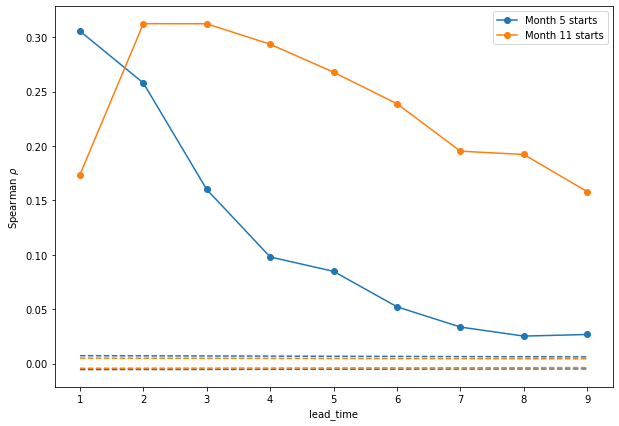

In [76]:
plt.figure(figsize=(10,7))

for idx, month in enumerate(np.unique(fcst_acc.init_date.dt.month)):
    fcst_acc_mon = fcst_acc.where(
        fcst_acc.init_date.dt.month == month, drop=True)
    sample_corrs = my.mean_correlation_ensemble_combinations(
        remove_ensemble_mean_trend(
            fcst_acc_mon[VARIABLE]).to_dataset(name=VARIABLE))
#     sample_corrs = my.mean_correlation_ensemble_combinations(
#             fcst_acc_mon)
    
    n_init_dates = len(fcst_acc_mon.init_date)
    n_ensembles = len(fcst_acc_mon.ensemble)
    
    null_corrs = my.n_random_resamples(
    fcst_acc_mon.stack(sample=('init_date','lead_time','ensemble')),
    samples={
        'sample': (n_init_dates * n_ensembles, 1)},
    n_repeats=N_BOOTSTRAPS,
    function=_pseudo_correlations,
    function_kwargs={'sample_dim': 'sample', 
                     'n_init_dates': n_init_dates, 
                     'n_ensembles': n_ensembles},
    with_dask=True)
    
    plt.plot([1,9],
             [null_corrs[VARIABLE].quantile(0.025),null_corrs[VARIABLE].quantile(0.05)], 
             color=f'C{idx}', linestyle='--')
    plt.plot([1,9],
             [null_corrs[VARIABLE].quantile(0.975),null_corrs[VARIABLE].quantile(0.95)], 
             color=f'C{idx}', linestyle='--')
    sample_corrs[VARIABLE].plot(color=f'C{idx}', marker='o', label=f'Month {month} starts')

plt.legend()
plt.ylabel(r'Spearman $\rho$');

# Test the fidelity using a 1D KS test

In [98]:
min_lead_year = 3
fcst_acc = fcst_acc.sel(lead_time=slice(min_lead_year,None))

In [99]:
fcst_super = my.mask_time_period(
    fcst_acc, TEST_PERIOD).stack(sample=['init_date','ensemble'])
obsv_super = my.mask_time_period(
    obsv_acc, TEST_PERIOD).stack(sample=['time'])

In [100]:
D, p = xks.ks1d2s(obsv_super, fcst_super, sample_dim='sample')

### What about with boostrapping?
Note that Nans in the fcst dataset mean that the sample size of the resampled distribution is reduced relative to the sample size of the observations. If we try to increase the sample size to roughly compensate for this, bootstrapping gives similar results to using the scipy p-values

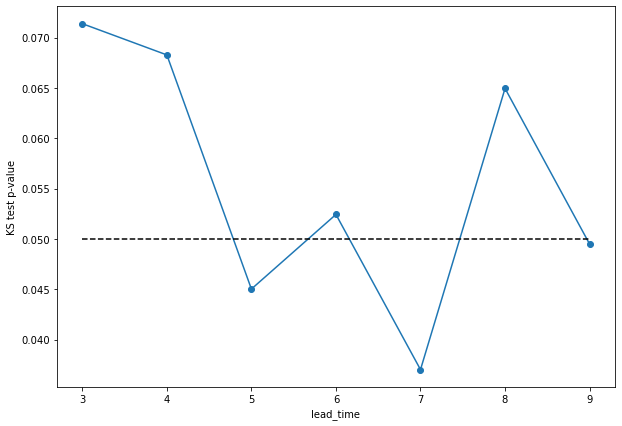

In [101]:
plt.figure(figsize=(10,7))
p[VARIABLE].plot(marker='o')
#p_mc['precip'].plot()
plt.plot([min_lead_year,9],[0.05,0.05],'k--')

plt.ylabel('KS test p-value');

# Look at the distributions

<BarContainer object of 29 artists>

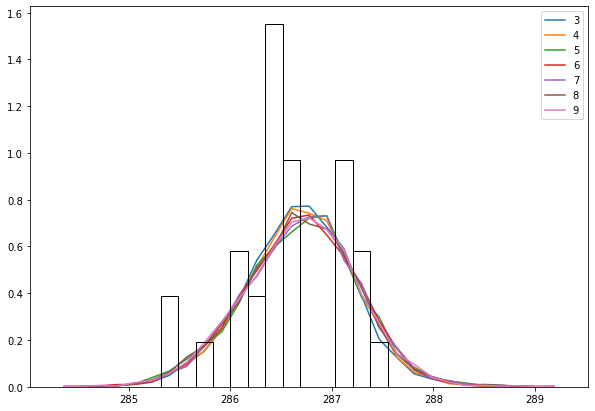

In [102]:
plt.figure(figsize=(10,7))

bins = np.linspace(fcst_super[VARIABLE].min(),
                   fcst_super[VARIABLE].max(),
                   30)

for lead in fcst_super.lead_time:
    data = fcst_super[VARIABLE].sel(lead_time=lead).values
    hist, bin_edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, hist, zorder=1)
plt.legend(fcst_super.lead_time.values)
    
data = obsv_super[VARIABLE].values
hist, bin_edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1]-bin_edges[0]
plt.bar(bin_centers, hist, width=bin_width, edgecolor='k', facecolor='none', zorder=2)

# Plot the return periods

In [103]:
periods = [slice('1990', '1999'),
           slice('2000', '2009'),
           slice('2010', '2019'),
           slice('2020', '2029')]

In [104]:
import dask.bag as db
def likelihoods_of_exceedance(*variables, event=None, with_dask=False):
    """ Get empirical likelihoods of exceeding all combinations of the input variables.
        If event is provided, it should be a list of the same length as the number of
        variables
    """
    def _loe(reference):
        mask = variables[0] >= reference[0]
        for i in range(1,len(reference)):
            mask &= variables[i] >= reference[i]
        return 100 * mask.mean().values
    
    if event is None:
        references = zip(*variables)
        single_event = False
    else:
        if not isinstance(event, list):
            raise ValueError('event should be a list of the same length as the number of variables')
        assert len(variables) == len(event)
        references = [event]
        single_event = True

    if with_dask & (single_event == False):
        b = db.from_sequence(references, npartitions=100)
        likelihoods = np.array(b.map(_loe).compute())
    else:
        likelihoods = np.array([_loe(reference) for reference in references])
    
    return *(variable.values for variable in variables), likelihoods

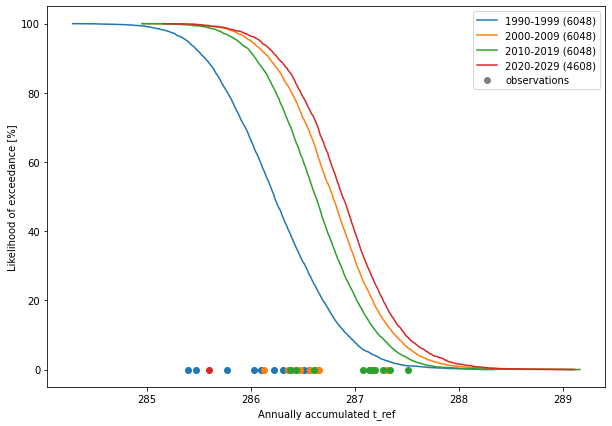

In [105]:
plt.figure(figsize=(10,7))

# Just focus on Nov starts for now so that we have roughly equal number of samples in each period
fcst_acc_NOV = fcst_acc.where(
        fcst_acc.init_date.dt.month == 11, drop=True)

for idx, period in enumerate(periods):
    fcst_super = my.mask_time_period(
        fcst_acc_NOV, period).stack(
        sample=['init_date','ensemble','lead_time']).dropna('sample')
    
    mult = -1 if VARIABLE == 'precip' else 1
    l_fcst = likelihoods_of_exceedance(mult * fcst_super[VARIABLE], with_dask=True)
    to_sort = np.argsort(l_fcst[0])
    plt.plot(mult * l_fcst[0][to_sort], l_fcst[1][to_sort], 
             color=f'C{idx}', label=f'{period.start}-{period.stop} ({len(fcst_super.sample)})')
    
    obsv_data = my.mask_time_period(obsv_acc, period)
    plt.plot(obsv_data[VARIABLE], np.zeros_like(obsv_data[VARIABLE]), 
             marker='o', linestyle='none', color=f'C{idx}')
    
plt.plot(np.nan, np.nan, 
         marker='o', linestyle='none', color='gray', label='observations')

if VARIABLE == 'precip':
    plt.gca().invert_xaxis()
plt.xlabel(f'Annually accumulated {VARIABLE}')
plt.ylabel(f'Likelihood of exceedance [%]')
plt.legend()

# Focus on particular year

In [89]:
year = 2001 # 2015, 2006

In [90]:
print(f'Likelihood of exceeding observed {year} conditions:')
for idx, period in enumerate(periods):
    fcst_super = my.mask_time_period(
        fcst_acc_NOV, period).stack(
        sample=['init_date','ensemble','lead_time']).dropna('sample')
    l = likelihoods_of_exceedance(
        mult * fcst_super[VARIABLE], 
        event=[mult * obsv_acc[VARIABLE].sel(time=str(year))])[1]
    print(f'    {period.start}-{period.stop}: '+
          f'{l[0]:.1f}% (1 in {100/l[0]:.0f} years)')

Likelihood of exceeding observed 2001 conditions:
    1990-1999: 8.4% (1 in 12 years)
    2000-2009: 38.5% (1 in 3 years)
    2010-2019: 17.5% (1 in 6 years)
    2020-2029: 38.7% (1 in 3 years)


# End

In [22]:
cluster.close()
client.close()